# Lab 6: Convolutional Neural Networks

## Intro

In the previous lab we dove into Deep Learning, we built our first real model, and hopefully demystified a lot of the complicated stuff. Now it's time to start applying Deep Learning to a kind of data where it shines: images! 

At the root of it, what is an image? The relations between nearby pixels encode the information in an image. A slightly darker or lighter image still contains the same information. Similarly, to recognize an object, its exact position doesn't matter. **Convolutional Neural Networks** (CNN), as we will discover in this lab, can encode much information about relations between nearby pixels. This makes them great tools to work with images, as well as with sequences like sounds and movies.

In this section, we will learn what convolutions are, how they can be used to filter images, and how Convolutional Neural Nets work. By the end of this section, we will train our first CNN to recognize handwritten digits. We will also introduce the core concept of **Tensor**. Are you ready? Let's go!

## Machine Learning on images with pixels

Image classification or image recognition is the process of identifying the object contained in an image. The classifier receives an image as input, and it returns a label indicating the object represented in the image.

Consider this image:

![Picture of a cat](./assets/pexels-cat.PNG)

Humans quickly recognize a cat, whereas the computer sees a bunch of pixels and has no prior notion of what a cat is, nor that a cat is in this image. It may seem magic that Neural Networks can solve the image classification problem well, but we hope that, by the end of this lab, how they do it will be quite clear!

To understand why it is so difficult for a computer to classify objects in images let's start from how they represent images, and in particular, let's start with a black and white image.

A black and white image is a grid of points, each point with a binary value. We call these points [**pixels**](https://en.wikipedia.org/wiki/Pixel), and in a black and white image, they only carry two possible values: 0 and 1.

Let's create a random Black and White image with Python. As always, we start by importing the common libraries. By now they should be familiar, but if you need a reminder, feel free to have a look at [Lab 1](1_Getting_Started.ipynb#First-Deep-Learning-Model):

In [1]:
with open('common.py') as fin:
    exec(fin.read())

In [2]:
with open('matplotlibconf.py') as fin:
    exec(fin.read())

Let's use the `np.random.binomial` function to generate a 10x10 square matrix of random zeros and ones. Using the `np.random.binomial()` method will give us an approximately equal amount of zeros and ones.

> TIP: according to the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.binomial.html), `np.random.binomial` creates a random distribution where samples are drawn from a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):
>
    binomial(n, p, size=None)
    Draw samples from a binomial distribution.
>
with _n_ (>= 0) is the number of trials and _p_ (in the interval [0,1]) is the probability of success.

We will use the argument `size=(10, 10)` to specify that we want an array with 2 axes, each with 10 positions:

In [3]:
bw = np.random.binomial(1, 0.5, size=(10, 10))

Let's print out the array `bw`:

In [4]:
bw

array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 1],
       [1, 1, 1, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 0, 1, 1]])

As promised, it's a random set of zeros and ones. We can also use the function `matplotlib.pyplot.imshow` to visualize it as an image. Let's do it:

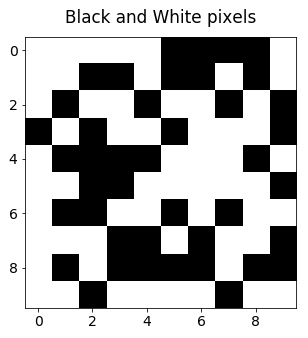

In [5]:
plt.imshow(bw, cmap='gray')
plt.title("Black and White pixels");

Awesome! We have just learned how to create a Black and White image with Python. Let's now generate a grayscale image.

To generate a grayscale image we allow the pixels to carry values that are intermediate between 0 and 1. Since we do not care about infinite possible shades of gray, we usually use unsigned integers with 8 bits, i.e., the numbers from 0 to 255.

A 10x10 grayscale image with 8-bit resolution is a grid of numbers, each-of-which is an integer between 0 and 255. 

Let's draw one such image. In this case, we will use the `np.random.randint` function, which generates random integers uniformly distributed between a low and a high extreme. Here's a snippet from the documentation:

> TIP: from the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html) of `np.random.randint`:
>
    randint(low, high=None, size=None, dtype='l')
>
    Return random integers from `low` (inclusive) to `high` (exclusive).
    _Low_ and _high_ are the lowest (signed) and largest integer to be drawn from the distribution.

In [6]:
gs = np.random.randint(0, 256, size=(10, 10))

Let's print out the array `gs`:

In [7]:
gs

array([[110,  29, 202, 108,  35, 112, 216, 147, 141, 162],
       [148, 243,  88,  64, 168,  97,  35, 210,  41, 169],
       [ 93, 141,  95,  83,  90, 251, 174, 212, 173, 205],
       [ 56,  27,  88, 241,  80,  36,  75, 155, 189,  77],
       [  1,   7, 253,   4,  47, 235,  19,  77, 110,  15],
       [  4,  99, 222,  21,  18,  77, 200, 244, 144, 141],
       [ 21, 166, 184, 119, 129,  56, 165,  52, 238, 164],
       [208, 215, 233, 194,  67,  33,  33, 115, 196,  39],
       [248, 176, 166,  36,  74,  49, 206,  73, 245,  86],
       [ 86, 177,  70,  83, 168, 190,  20, 212, 113, 252]])

As expected it's a 10x10 grid of random integers between 0 and 255. Let's visualize it as an image:

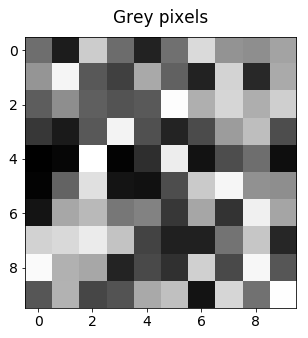

In [8]:
plt.imshow(gs, cmap='gray')
plt.title("Grey pixels");

Wonderful! In image classification problems we have to think of images as the input into the algorithm, therefore, this 2D array with 100 numbers, corresponds to one data point in a classification task. How could we train a Machine Learning algorithm on such data? Let's say we have many such gray-scale images representing handwritten digits. How do we feed them to a Machine Learning model?

### MNIST

The [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a very famous dataset of handwritten digits and it has become a benchmark for image recognition algorithms. It consists of 70000 images of 28 pixel by 28 pixels, each representing a handwritten digit.

> TIP: Think of how many real-world applications involve recognition of handwritten digits:
- zipcodes
- tax declarations
- student tests
- ...

The target variables are the ten digits from 0 to 9.

Keras has it's built-in dataset for MNIST, so we will load it from there using the `load_data` function

In [9]:
from tensorflow.keras.datasets import mnist

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Let's check the shape of the arrays of the data we received for the training and test sets:

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
X_test.shape

(10000, 28, 28)

The loaded data is a numpy array of order 3. It's like a 3-dimensional matrix, whose elements are identified by 3 indices. We'll discuss these more in detail later in this lab.

For now, it is sufficient to know that the first index (running from 0 to 59999 for `X_train`) locates a specific image in the dataset, while the other two indices determine a particular pixel in the picture, i.e., they run from 0 to the height and width of the image.

For instance, we can select the first image in the training set and take a look at its shape by using the first index:

In [13]:
first_img = X_train[0]

This image is a 2D array of numbers between 0 and 255, like this:

![The first number in the mnist training set is a 5](./assets/mnist_0.png)

Let's use `plt.imshow` once again to display the image:

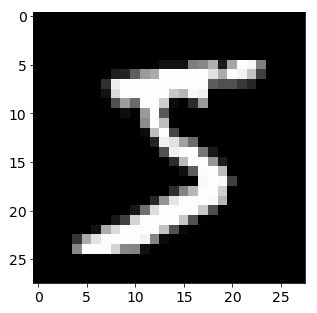

In [14]:
plt.imshow(first_img, cmap='gray');

Notice that with the `gray` colormap, zeros are displayed as black pixels while higher numbers are displayed as lighter pixels.

### Pixels as features

How can we use this whole image as an input to a classification algorithm?

So far our input datasets have always been 2D tabular sets, where table columns refer to different features and each data point occupies a row. In this case, each data point is itself a 2D table (an image), and so we need to decide how to map it to features. 

The simplest way to feed images to a Machine Learning algorithm is to use each pixel in the picture as an individual feature. If we do this, we will have $28 \times 28 = 784$ independent features, each one being an integer between 0 and 255, and our dataset will become tabular once again. Each row in the tabular dataset will represent a different image, and each of the 784 columns will designate a specific pixel.

The `reshape` method of a numpy array allows us to reshape any array to a new shape. For example, let's reshape the training dataset to be a tabular dataset with 60000 rows and 784 columns:

In [15]:
X_train_flat = X_train.reshape((60000, 784))

We can check that the operation worked by printing the shape of `X_train_flat`:

In [16]:
X_train_flat.shape

(60000, 784)

Wonderful! Another valid syntax for `reshape` is to just specify the size of the dimensions we care about and let the method figure out the other dimension, like this:

In [17]:
X_test_flat = X_test.reshape(-1, 28*28)

Again, let's print the shape to be sure:

In [18]:
X_test_flat.shape

(10000, 784)

Great! Now we have 2 tabular datasets like the ones we are familiar with. The features contain values between 0 and 255:

In [19]:
X_train_flat.min()

0

In [20]:
X_train_flat.max()

255

As already seen in [Lab 3](3_Machine_Learning.ipynb#Feature-Transformations), Neural Network models are quite sensitive to the absolute size of the input features, and hence they like features that are normalized to be somewhat near 1. 

We should rescale the values of our features to be between 0 and 1. Lets do it by dividing them by 255 so they will have values between 0 and 1. Notice that we need to convert the the data type to `float32` because under the hood numpy arrays are implemented in C and therefore are strongly typed.

In [21]:
X_train_sc = X_train_flat.astype('float32') / 255.0
X_test_sc = X_test_flat.astype('float32') / 255.0

Great! We now have 2D data that we can use to train a fully connected Neural Network!

### Multiclass output

Since our goal is to recognize a digit contained in an image, our final output is a class label between 0 and 9. Let's inspect `y_train` to look at the target values we want to train our network to learn:

In [22]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

We can use the `np.unique` method to check what are the unique values for the labels, these should be the digits from 0 to 9:

In [23]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

`y_train` is an array of target digits, and it contains values between 0 and 9.

Since there are ten possible output classes, this is a Multiclass classification problem where the outputs are mutually exclusive. As we have learned in the [Lab 4](4_Deep_Learning.ipynb#Multiclass-classification), we need to convert the labels to a matrix of binary columns. In doing so, we communicate to the network that the labels are distinct and it should learn to predict the probability of an image to correspond to a specific label.

In other words, our goal is to build a network with 784 inputs and 10 output, like the one represented in this figure:

![Fully connected network to solve MNIST](./assets/mnist_fc.png)

So that for a given input image the network learns to indicate to which label it corresponds. Therefore we need to make sure that the shape of the label array matches the output of our network.

We can convert our labels to binary arrays using the `to_categorical` utility function from `tensorflow.keras`. Let's import it

In [24]:
from tensorflow.keras.utils import to_categorical

and let's convert both `y_train` and `y_test`:

In [25]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

Let's double check what's going on. As we have seen before, the first element of `X_train` is a handwritten number 5. So the corresponding label should be a 5.

In [26]:
y_train[0]

5

The corresponding binary version of the label is the following array:

In [27]:
y_train_cat[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

As you can see, this is an array of 10 numbers, zero everywhere except at position 5 (remember we start counting from 0) indicating which of the 10 classes our image should be classified as.

As seen in [Lab 3 for features](./03_Machine_Learning.ipynb#Categorical-Features) and in [Lab 4 for labels](./04_Deep_Learning.ipynb#Mutually-exclusive-classes), this type of encoding is called *one-hot* encoding, meaning we encode classes as an array with as many elements as the number of distinct classes, zero everywhere except for a 1 at the corresponding class.

Great! Finally let's check the shape of `y_train_cat`. This should have as many rows as we have training examples and 10 columns for the 10 binary outputs:

In [28]:
y_train_cat.shape

(60000, 10)

Let's check our test dataset to make sure it matches as well. 

In [29]:
y_test_cat.shape

(10000, 10)

Fantastic! We can now train a fully connected Neural Network using all what we've learned in the previous labs.

### Fully connected on images

To build our network, let's import the usual Keras classes as seen in [Lab 1](1_Getting_Started.ipynb#Keras). Once again we build a `Sequential` model, i.e. we add the layers one by one, using fully connected layers, i.e. `Dense`:

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Now let's build the model. As we have done in [Lab 4](4_Deep_Learning.ipynb#Deep-model), we will build this network layer by layer, making sure that the sizes of the input/outputs.

The network configuration will be the following:

- Input: 784 features
- Layer 1: 512 nodes with Relu activation
- Layer 2: 256 nodes with Relu activation
- Layer 3: 128 nodes with Relu activation
- Layer 4: 32 nodes with Relu activation
- Output Layer: 10 nodes with Softmax activation

Notice a couple of things:

1. We specify the size of the input in the definition of the first layer through the parameter `input_dim=784`.
- The choice of the number of layers and the number of nodes per layer is arbitrary. Feel free to experiment with different architectures and observe:
    - if the network performs better or worse
    - if the training takes longer or shorter (number of epochs to reach a certain accuracy)
- The last layer added to the stack is also the output layer. This may be sometimes confusing, so make sure that the number of nodes in the last layer in the stack corresponds to the number of categories in your dataset
- The last layer has a `Softmax` activation function at its output. As seen in [Lab 4](4_Deep_Learning.ipynb#Mutually-exclusive-classes), this is needed when the classes are mutually exclusive. In this case, an image of a digit cannot be of 2 different digits at the same time, and we need to let the model know about it.
- Finally, the model is compiled using the `categorical_crossentropy` loss, which is the correct one for classifications with many mutually exclusive classes.

In [31]:
model = Sequential()

model.add(Dense(512, input_dim=784, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))  # output

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Let's print out the model summary:

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 570,602
Trainable params: 570,602
Non-trainable params: 0
_________________________________________________________________


As you can see, the model has about half a million parameters, namely 570,602.

Let's train it on our data for ten epochs with 128 images per batch. We will need to pass the _scaled and reshaped_ inputs and outputs.

Also, let's use a `validation_split` of 10%, meaning we will train the model on 90% of the training data, and evaluate its performance on the remaining 10%. This is like an internal train/test split done on the training data. It's useful when we plan to change the network and tune its architecture to maximize its ability to generalize. We will keep the actual test set for a final check once we have committed to the best architecture.

In [33]:
h = model.fit(X_train_sc, y_train_cat, batch_size=128,
              epochs=10, verbose=1,
              validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 38us/sample - loss: 0.2775 - accuracy: 0.9139 - val_loss: 0.1155 - val_accuracy: 0.9673
Epoch 2/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.1014 - accuracy: 0.9691 - val_loss: 0.0888 - val_accuracy: 0.9748
Epoch 3/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.0667 - accuracy: 0.9799 - val_loss: 0.0881 - val_accuracy: 0.9760
Epoch 4/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.0506 - accuracy: 0.9854 - val_loss: 0.0871 - val_accuracy: 0.9773
Epoch 5/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.0628 - val_accuracy: 0.9828
Epoch 6/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0831 - val_accuracy: 0.9827
Epoch 7/10
54000/54000 [==============================] -

The model seems to be doing very well on the training data (as we can see by the `acc` output). 

Let's check if it is overfitting, i.e., if it is just memorizing the answers instead of learning general rules about the training examples


> TIP: if you need to refresh your knowledge of overfitting have a look at [Lab 3](3_Machine_Learning.ipynb#Train-/-Test-split. ) as well as [this Wikipedia article](https://en.wikipedia.org/wiki/Overfitting).

Let's plot the history of the accuracy and compare the training accuracy with the validation accuracy.

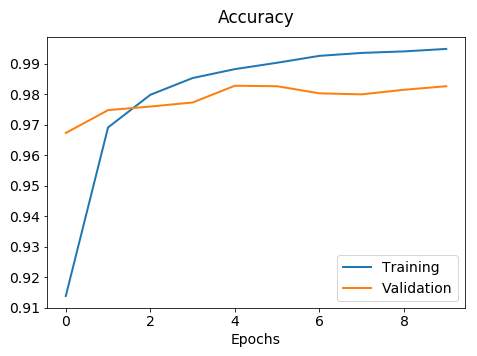

In [34]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs');

We already notice that while the training accuracy increases, the validation accuracy does not seem to increase as well. Let's check the performance on the test set:

In [35]:
test_acc = model.evaluate(X_test_sc, y_test_cat)[1]
test_acc

10000/10000 [==============================] - 0s 49us/sample - loss: 0.0957 - accuracy: 0.9797


0.9797

and let's compare it with the performance on the training set:

In [36]:
train_acc = model.evaluate(X_train_sc, y_train_cat)[1]
train_acc

60000/60000 [==============================] - 3s 49us/sample - loss: 0.0187 - accuracy: 0.9954


0.9954

The performance on the test set is lower than the performance on the training set. 

> TIP: one question you may have is "When is a difference between the test and train scores significant". We can answer this question by running cross-validation to see what the standard deviation of each score is. Then we can compare their difference between the two scores with the standard deviation and see if their difference is much higher than the statistical fluctuations of each score.

This difference between the train and test scores may indicate we are overfitting.

This indication makes sense because the model is trained using the individual pixels as features. This implies that two images which are similar but slightly rotated or shifted have entirely different features.

To go beyond "pixels as features" we need to extract better features from the images.

## Beyond pixels as features

In the previous example, we trained a model to recognize handwritten digits using the raw values of the pixels as input features. The model performed pretty well on the training data but had some trouble generalizing to the test set. Intuitively it's quite clear where the problem is: the absolute value of each pixel is not a great feature to describe the content of an image. To understand this, realize that you would still recognize the digits if black turned to gray and white turned to a lighter gray.  This is because an image carries information in the arrangements of nearby pixels, not just in the value of each pixel.

It is legitimate to wonder if there is a better way to extract information from images, and there is.

The process of going from an image to a vector of pixels is just the simplest case of **feature extraction** from an image. There are many other methods to extract features from images, including [**Fourier transforms**](https://en.wikipedia.org/wiki/Fourier_transform), [**Wavelet transforms**](https://en.wikipedia.org/wiki/Wavelet_transform), [**Histograms of oriented gradients (HOG)**](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) and many others. These are all methods that take an image in input and return a vector of numbers we can use as features.

The banknotes dataset we used in the previous lab is an example of features extracted from images with these methods.

![Feature extraction](./assets/feature_extraction.png)

Although powerful, these methods require profound domain knowledge, and each was developed over time to solve a specific problem in image recognition. It would be great if we could avoid using these ad-hoc methods and learn the best features from the image problem itself.

This case is a general issue with feature engineering: identifying features that correctly represent the type of information we are trying to capture from a rich data point (like an image), is a time consuming and complex effort, often involving several Ph.D. students doing their thesis on it. 

Let's see if we can use a different approach.

### Using local information

Let's consider an image more in detail. What makes an image different from a vector of numbers is that the values of pixels are correlated both horizontally and vertically. It's the 2D pattern that carries the information contained in the image and these 2D patterns, like for example horizontal and vertical contrast lines, are specific to an image or a set of images. It would be great to have a technique that can capture them automatically.

Additionally, if all we care about is recognizing an object, we should strive to be insensitive to the position of the object in the image, and our features should rely more on local patterns of pixels arranged in the form of the object, than on the position of such pixels on the grid.

![Local patterns in images](./assets/banknote_horizontal_lines.png)

The mathematical operation that allows us to look for local patterns is called **convolution**. However, before we learn about it, we have to take a moment and learn about **Tensors**.

### Images as tensors

In this section, we talk about tensors. Tensors are common in Physics and Mathematics. However, the tensors we use in Machine Learning are not the same as the ones used in physics. **Tensors in Machine Learning** are just a synonym of **Multi-dimensional arrays**. This is somewhat misleading and has generated a bit of a debate ([see here](https://stats.stackexchange.com/questions/198061/why-the-sudden-fascination-with-tensors/198064)), but we will proceed as the mainstream convention and use the word tensors to refer to multi-dimensional arrays.

In this sense, the **order** or **rank** of a tensor refers to the number of axes in the array.

> TIP: people tend to use the word **dimension** to indicate the rank of a tensor (number of axes) as well as the length of a specific axis. We will call the former rank or order, saving the word dimension for the latter. More on this later, however.

You may wonder why you should learn about tensors. The answer is, they allow you to apply Machine Learning to multi-dimensional data like images, movies, text and so on. Tensors are a great way to extend our skills beyond the tabular datasets we've used so far!

Let's start with **scalars**. Scalars are just numbers, everyday numbers we are used to. They have no dimension.

In [37]:
5

5


**Vectors** can be thought of as lists of numbers. The number of elements in a vector is also called **vector length** and sometimes **number of dimensions**. As already seen many times, in `python` we can create vectors using the `np.array` constructor:

In [38]:
v = np.array([1, 3, 2, 1])
v.shape

(4,)

We've just created a vector with 4 elements.

> TIP: In our terminology, this is a vector of dimension 4, which is still a tensor of order 1, since it only has one axis.

The numbers in the list are the coordinates of a point in a space with as many dimensions as the number of entries in the list.

Going up one level, we encounter tensors of order 2, which are called matrices. **Matrices** are tables of numbers with rows and columns, i.e., they have two axes.

In [39]:
M = np.array([[1, 3, 2, 2],
              [0, 1, 3, 2]])
M.shape

(2, 4)

The first axis of `M` has length 2, which is the number of rows in the matrix, the second axis has length 4, and it corresponds to the columns in the matrix.

A grayscale image, as we saw, is a 2D matrix where each entry corresponds to a pixel.

> TIP: notice that `plt.imshow` takes care of normalizing the values of the matrix so that we can display them in gray-scale.

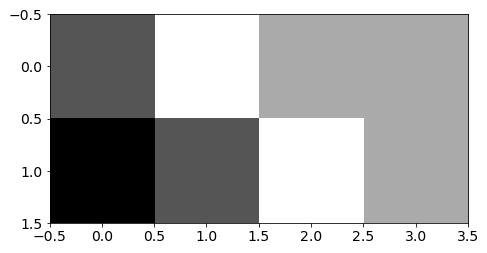

In [40]:
plt.imshow(M, cmap='gray');

A matrix is a list of vectors of the same length, each representing a row of pixels. In the same way, as a vector is a list of scalars. So if we extract the first element of the matrix, this is a vector:

In [41]:
M[0].shape

(4,)

This recursive construction allows us to organize them in the larger family of tensors. Tensors in Machine Learning can be understood as nested lists of objects of the previous order, all with the same shape.

![Tensors](./assets/tensor_table.png)

So for example, a tensor of order three can be thought of as an array of matrices, which are tensors of order two. Since all of these matrices have the same number of rows and columns, the tensor is actually like a cuboid of numbers.

![Multi-dimensional array](./assets/cuboid.png)

Each number is located by the row, the column and the depth where it is stored.

The shape of a tensor tells us how many objects there are when counting along a particular axis. So for example, a vector has only one axis, and a matrix has two axes, indicating the number of rows and the number of columns. Since most of the data (images, sounds, texts) we will use are stored as tensors, it is necessary to know the dimensions of these objects for proper use. 

### Colored images

A colored image is a set of gray-scale images each corresponding to a primary color channel. So, in the case of [RGB](https://en.wikipedia.org/wiki/RGB_color_model), we have three channels (Red, Blue, and Green), each containing the pixels of the image in that particular channel. 

This image is an order three tensor, and there are two major ordering conventions. If we think of the image as a list of three single-color images, then the axis order will be channel first, then height, and then width.

On the other hand, we can also think of the tensor as an order two list of vector pixels, where each pixel contains three numbers, one for each of the colors. We call this ordering _channel-last_,  and it's the convention used in the rest of the labs.

![Channel order when an image is represented as a tensor](./assets/channels_order.png)

Let's create and display a random color image by creating a list of random pixels between 0 and 255:

In [42]:
img = np.random.randint(255, size=(4, 4, 3),
                        dtype='uint8')
img

array([[[165,   4,  33],
        [178, 244, 208],
        [154,  13, 229],
        [217,  82,  40]],

       [[128, 204,  25],
        [  1, 176,  67],
        [ 15, 150, 201],
        [122,  92,  72]],

       [[144, 166, 153],
        [215, 170, 115],
        [115,  77, 223],
        [115, 135,  55]],

       [[  3,  63, 170],
        [210,  37, 192],
        [ 11,  33, 172],
        [251,  91, 232]]], dtype=uint8)

Now let's display it as a figure, showing each of the dominant pixels in each list. 

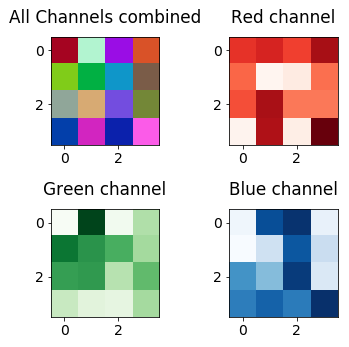

In [43]:
plt.figure(figsize=(5, 5))
plt.subplot(221)
plt.imshow(img)
plt.title("All Channels combined")

plt.subplot(222)
plt.imshow(img[:, : , 0], cmap='Reds')
plt.title("Red channel")

plt.subplot(223)
plt.imshow(img[:, : , 1], cmap='Greens')
plt.title("Green channel")

plt.subplot(224)
plt.imshow(img[:, : , 2], cmap='Blues')
plt.title("Blue channel")
plt.tight_layout()

Pause here for a second and observe how the colors of the pixels in the colored image reflect the combination of the colors in the three channels.

Now that we know how to represent images using tensors, we are ready to introduce convolutional Neural Networks.

> TIP: If you'd like to know a bit more about Tensors and how they work, we displayed a few operations in the [Appendix](./Appendix.ipynb#Tensors).

## Convolutional Neural Networks

Simply stated, convolutional Neural Networks are Neural Networks that replace the matrix multiplication operation $(X \cdot w)$ with the [convolution](https://en.wikipedia.org/wiki/Convolution) operation $(X * w)$ in at least one of their layers.

> TIP: if you need a refresher about convolutions and how they work, have a look at the [Appendix](./Appendix.ipynb#Convolutions).

For this lab, all we need to know is that we can convolve an image with a **filter** or **kernel**, which is a smaller image. The convolution generates a new image, also called a **feature map**, whose pixels represent the "degree of matching" of the corresponding **receptive field** with the kernel.

![Feature map and receptive field](./assets/feature_map.png)

So, if we take many filters and arrange them in a **convolutional layer** the output of the convolution of an image will be as many feature maps (convolved images) as there are filters. Since all of these images have the same size, we can arrange them in a tensor, where the number of channels corresponds to the number of filters used. Let's use tensors to describe everything: inputs, layers, and outputs.

We can arrange the input data is a tensor of order four. A single image is an order-3 tensor as we know, but since we have many input images in a batch, and they all have the same size, we might as well stack them in an order-4 tensor where the first axis indicates the number of samples.

So the four axes are respectively: the number of images in the batch, the height of the image, the width of the image and the number of color channels in the picture.

For example, in the MNIST training dataset, we have 60000 images, each with 28x28 pixel and only one color channel, because they are grayscale. This gives us an order-4 tensor with the shape `(60000, 28, 28, 1)`.

![Image represented as a tensor of order-4](./assets/order4tensor.png)

Similarly, we can stack the filters in the convolutional layer as an order-4 tensor. We will use the first two axes for the height and the weight of the filter. The third axis will correspond to the number of color channels in the input, while the last axis is for the number nodes in the layer, i.e., the number of different filters we are going to learn. This is also called the number of **output channels** sometimes, you'll soon see why.

Let's do an example where we build a convolutional layer with four 3x3 filters. The order-4 tensor has a shape of `(3, 3, 1, 4)`, i.e., four filters of 3x3 pixels each with a single input color channel each.

![Convolutional kernel represented as a tensor of order-4](./assets/filter4tensor.png)

When we convolve each input image with the convolutional layer, we still obtain an order-4 tensor. 

![Feature map represented as a tensor of order-4](./assets/output4tensor.png)

The first axis is still the number of images in the batch or the dataset. The other three axes are for the image height, width and number of color channels in the output. Notice that this is also the number of filters in the layer, four in the case of this example.

Notice that since the output is an order-4 tensor, we could feed it to a new convolutional layer, provided we make sure to match the number of channels correctly.

### Convolutional Layers

Convolutional layers are available in [`keras.layers.Conv2D`](https://keras.io/layers/convolutional/). Let's apply a convolutional layer to an image and see what happens.

First, let's import the `Conv2D` layer from keras:

In [44]:
from tensorflow.keras.layers import Conv2D

Now let's load an example image from [`scipy.misc`](https://docs.scipy.org/doc/scipy/reference/misc.html):

In [45]:
from scipy import misc

In [46]:
img = misc.ascent()

and let's display it:

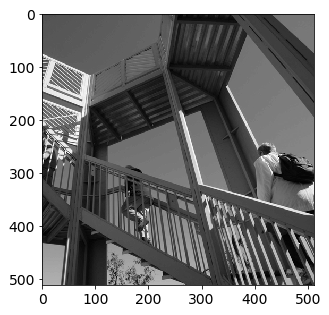

In [47]:
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray');

Let's check the shape of `img`:

In [48]:
img.shape

(512, 512)

A convolutional layer wants an order-4 tensor as input, so first of all we need to reshape our image so that it has 4 axes and not 2. 

We can add one axis of length 1 for the color channel (which is a grayscale pixel value between 0 and 255) and one axis of length 1 for the dataset index.

In [49]:
img_tensor = img.reshape((1, 512, 512, 1))

Let's start by applying a large flat filter of size 11x11 pixels. This operation should result in a blurring of the image because the pixels are averaged.

The syntax of[`Conv2D`](https://keras.io/layers/convolutional/) is:

    Conv2D(filters, kernel_size, ...)

so we will specify 1 for the `filter` and (11, 11) for the `kernel_size`. We will also initialize all the weights to one by using `kernel_initializer='ones'`. Finally we will need to pass the input shape, since this is the first layer in the network. This is the shape of a single image, which in this case is `(512, 512, 1)`.

In [50]:
model = Sequential()
model.add(Conv2D(1, (11, 11), kernel_initializer='ones',
                 input_shape=(512, 512, 1)))
model.compile('adam', 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 502, 502, 1)       122       
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


We have a model with one convolutional layer, so the number of parameters is equal to `11 x 11 + 1` where the +1 comes from the bias term. We can apply the convolution to the image by running a forward pass:

In [51]:
img_pred_tensor = model.predict(img_tensor)

To visualize the image we extract it from the tensor.

In [52]:
img_pred = img_pred_tensor[0, :, :, 0]

and we can use `plt.imshow` as before:

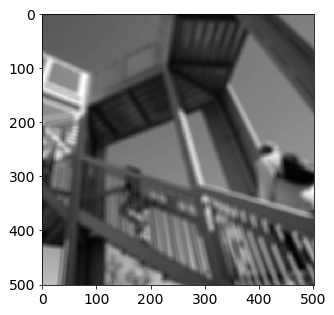

In [53]:
plt.imshow(img_pred, cmap='gray');

As you can see the image is blurred, as we expected.


> TIP: try to change the initialization of the convolutional layer to something else. Then re-run the convolution and notice how the output image changes.

Great! We have just demonstrated that the convolution with a kernel will produce a new image, whose pixels will be a combination of the original pixels in a receptive field and the values of the weights in the kernel.

The user does not decide these weights, the network learns them through backpropagation! This allows a Neural Network to adapt and learn any pattern that is relevant to solving the task.

There are two additional arguments to consider when building a convolutional layer with Keras: `padding` and `stride`.

#### Padding

If you've been paying attention, you may have noticed that the convolved image is slightly smaller than the original image:

In [54]:
img_pred_tensor.shape

(1, 502, 502, 1)

This is due to the default setting of `padding='valid'` in the `Conv2D` layer, and it has to do with how we treat the data at the boundaries. Each pixel in the convolved image is the result of the contraction of the receptive field with the kernel. Since, in this case, the kernel has a size of 11x11, if we start at the top left corner and slide to the right, there are only 502 possible positions for the receptive field. In other words, we lose 5 pixels on the right and 5 pixels on the left.

If we would like to preserve the image size, we need to offset the first receptive field so that its center falls on the top left corner of the input image. We can fill the empty parts with zeros. This is called padding.

![Padding](./assets/padding.png)

In `tensorflow.keras` we have two padding modes:
- `valid` which means **no padding**
- `same` which means **pad** to keep the same image size.

Let's check that _padding same_ works as expected:

In [55]:
model = Sequential()
model.add(Conv2D(1, (11, 11), padding='same', 
                 kernel_initializer='ones',
                 input_shape=(512, 512, 1)))
model.compile('adam', 'mse')

model.predict(img_tensor).shape

(1, 512, 512, 1)

Awesome! We know how padding works. Why use padding? We can use padding if we think that the pixels at the border contain useful information to solve the classification task.

#### Stride

The **stride** is the number of pixels that we use that separate one receptive field from the next. It's like the step size in the convolution. A stride of `(1, 1)` means we slide the receptive field by one pixel horizontally and one vertically. Looking at the figure:

![Stride](./assets/stride.png)

The input image has size 6x6, the filter (not shown) is 3x3 and so is the receptive field. If we perform convolution with no padding and stride of 1, the output image will lose one pixel on each side, resulting in a 4x4 image. Increasing the stride means skipping a few pixels between one receptive field and the next, so, for example, a stride of `(3, 3)`, will produce an output image of 2x2.

We can also stride of different length in the two directions, which will produce a rectangular convolved output image.

Finally, if we don't want to lose the borders during the convolution, we can pad the image with zeros and obtain an image with the same size as the input.

The default value for the stride is  1 to the right and 1 down, but we can jump by more significant amounts, for example, if the image resolution is too high.

This will produce output images that are smaller. For example, let's jump by 5 pixels in both directions in our example:

In [56]:
model = Sequential()
model.add(Conv2D(1, (11, 11), strides=(5, 5),
                 padding='same',
                 kernel_initializer='ones',
                 input_shape=(512, 512, 1)))
model.compile('adam', 'mse')

small_img_tensor = model.predict(img_tensor)
small_img_tensor.shape

(1, 103, 103, 1)

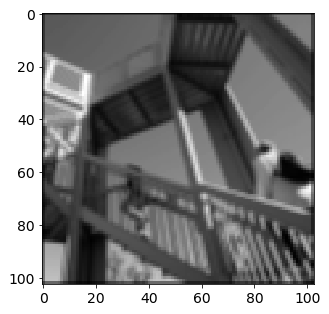

In [57]:
plt.imshow(small_img_tensor[0, :, :, 0], cmap='gray');

The image is still present, but its resolution is now much lower. We can also choose asymmetric strides, if we believe the image has more resolution in one direction than another:

In [58]:
model = Sequential()
model.add(Conv2D(1, (11, 11), strides=(11, 5),
                 padding='same', 
                 kernel_initializer='ones',
                 input_shape=(512, 512, 1)))
model.compile('adam', 'mse')

asym_img_tensor = model.predict(img_tensor)
asym_img_tensor.shape

(1, 47, 103, 1)

### Pooling layers

Another layer we need to learn about is the pooling layer.

Pooling reduces the size of the image by discarding some information. For example, max-pooling only preserves the maximum value in a patch and stores it in the new image, while dropping the values in the other pixels.

Also, pooling patches usually do not overlap, which reduces the size of the image.

If we apply pooling to the feature maps, we end up with smaller feature maps, that still retain the highest matches of our convolutional filters with the input.

Average pooling is similar, only using average instead of max.

These layers are available in `tensorflow.keras` as `MaxPooling2D` and `AveragePooling2D`.

In [59]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D

Let's add a `MaxPooling2D` layer in a simple network (containing this single layer):

In [60]:
model = Sequential()
model.add(MaxPooling2D(pool_size=(5, 5),
                       input_shape=(512, 512, 1)))
model.compile('adam', 'mse')

and let's apply it to our example image:

In [61]:
img_pred = model.predict(img_tensor)[0, :, :, 0]
img_pred.shape

(102, 102)

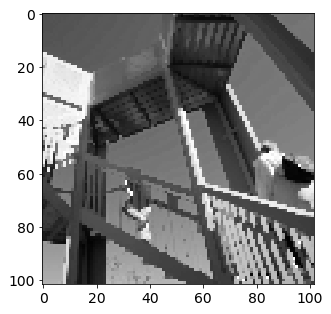

In [62]:
plt.imshow(img_pred, cmap='gray');

Max-pooling layers are useful in tasks of object recognition, since pixels in feature maps represent the "degree of matching" of a filter with a receptive field, keeping the max keeps the highest matching feature. 

On the other hand, if we are also interested in the location of a particular match, then we shouldn't be using max-pooling, because we lose the location information in the pooling operation. 

Thus, for example, if we are using a Convolutional Neural Network to read the state of a video game from a frame, we need to know the exact positions of players and thus using max-pooling is not recommended.

Finally `GlobalMaxPooling2D` calculates the global max in the image, so it returns a single value for the image:

In [63]:
model = Sequential()
model.add(GlobalMaxPooling2D(input_shape=(512, 512, 1)))
model.compile('adam', 'mse')

In [64]:
img_pred_tensor = model.predict(img_tensor)
img_pred_tensor.shape

(1, 1)

### Final architecture

Convolutional, pooling and activation layers can be stacked together, feeding the output of one layer into the input of the next. This stacking results in a feature-extraction pipeline that will gradually transform an image into a tensor with more channels and fewer pixels:

![Convolutional stack](./assets/conv_stack.png)

The value of each "pixel" in the last feature map is influenced by a large regions of the original image and it will have learned to recognize complex patterns.

That's the beauty of stacking convolutional layers. The first layers will learn patterns of pixels in the original image, while deeper layers will learn more complex patterns that are combinations of the simpler patterns. 

In practice, early layers will specialize to recognize contrast lines in different orientations, while deeper layers will combine those contrast lines to identify parts of objects. The typical example of this is the face recognition task where middle layers recognize facial features like eyes, noses, and mouths while deeper nodes specialize on individual faces.

The convolutional stack behaves like an optimized feature extraction pipeline that is trained to solve the task at hand optimally.

To complete the pipeline and solve the classification task we can pipe the output of the feature extraction pipeline into a fully connected final stack of layers.

We will need to unroll the output tensor into a long vector (as we did initially for the MNIST data) and connect this vector to the labels using a fully connected network.

![Flatten layer](./assets/flatten_fc.png)

We can also stack multiple fully connected layers if we want. Our final network is like a pancake of many layers, the convolutional part dealing with feature extraction and the fully connected part handling the classification.

The deeper we go in the network the richer and more unique are the patterns matched and so more robust the classification will be.

### Convolutional network on images

Let's build our first convolutional Neural Network to classify the MNIST data. First of all we need to reshape the data as order-4 tensors. We will store the reshaped data into new variables called `X_train_t` and `X_test_t`.

In [65]:
X_train_t = X_train_sc.reshape(-1, 28, 28, 1)
X_test_t = X_test_sc.reshape(-1, 28, 28, 1)

In [66]:
X_train_t.shape

(60000, 28, 28, 1)

Then we import the `Flatten` and `Activation` layers:

In [67]:
from tensorflow.keras.layers import Flatten, Activation

Let's now build a simple model with the following architecture:

- A `Conv2D` layer with 32 filters of size 3x3.
- A `MaxPooling2D` layer of size 2x2.
- An activation layer with a `ReLU` activation function.
- A couple of fully connected layers leading to the output of 10 classes corresponding to the digits.

Notice that between the convolutional layers and the fully connected layers we will need `Flatten` to reshape the feature maps into feature vectors.

To speed up the convergence, we initialize the convolutional weights drawing from a random normal distribution. Later in the labs, we will discuss initializations more in detail.

Also notice that we need to pass `input_shape=(28, 28, 1)` to let the model know our input images are grayscale 28x28 images:

In [68]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1),
                 kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                346176    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
________________________________________________

This model has 300k parameters, that's almost half of the fully connected model we designed at the beginning of this lab. Let's train it for five epochs. Notice that we pass the tensor data we created above:

In [69]:
h = model.fit(X_train_t, y_train_cat, batch_size=128,
              epochs=5, verbose=1, validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 2s 48us/sample - loss: 0.3411 - accuracy: 0.9005 - val_loss: 0.1720 - val_accuracy: 0.9496
Epoch 2/5
42000/42000 [==============================] - 2s 40us/sample - loss: 0.1142 - accuracy: 0.9668 - val_loss: 0.0948 - val_accuracy: 0.9728
Epoch 3/5
42000/42000 [==============================] - 2s 40us/sample - loss: 0.0707 - accuracy: 0.9798 - val_loss: 0.0745 - val_accuracy: 0.9782
Epoch 4/5
42000/42000 [==============================] - 2s 41us/sample - loss: 0.0525 - accuracy: 0.9848 - val_loss: 0.0730 - val_accuracy: 0.9782
Epoch 5/5
42000/42000 [==============================] - 2s 41us/sample - loss: 0.0415 - accuracy: 0.9875 - val_loss: 0.0698 - val_accuracy: 0.9793


Like before, we can display the training history:

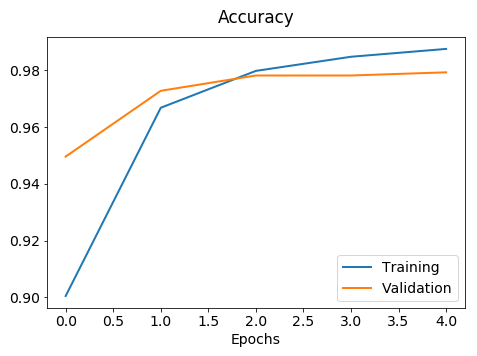

In [70]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs');

and compare the accuracy on train and test sets:

In [71]:
train_acc = model.evaluate(X_train_t, y_train_cat,
                           verbose=0)[1]
test_acc = model.evaluate(X_test_t, y_test_cat,
                          verbose=0)[1]

print("Train accuracy: {:0.4f}".format(train_acc))
print("Test accuracy: {:0.4f}".format(test_acc))

Train accuracy: 0.9869
Test accuracy: 0.9808


The convolutional model achieved a better performance on the MNIST data in fewer epochs. Overfitting also decreases, because the model is learning to combine spatial patterns instead of learning the exact values of the pixels.

## Beyond images

Convolutional networks are great on all data types where the order matters. For example, they can be used on sound files using spectrograms. Spectrograms represent sound as an image where the vertical axis corresponds to the frequency bands, while the horizontal axis indicates the time. We can feed spectrograms to a convolutional layer and treat it like an image. Some of the most famous speech recognition engines use this technique.

Similarly, we can map a sentence of text onto an image where the vertical axis indicates the word index in a dictionary, and the horizontal axis is for the position of the word in the sentence.

Although they appear in many models and domains, CNNs are not useful at all in some case. Since they are good at capturing spatial patterns, they are of no use when such local patterns do not exist. This is the case when data is a 2D table coming from a database collecting user data. Each row corresponds to a user and each column to a feature, but there is no particular order in either columns or rows. 

In other words, we can swap the order of the rows or the columns without altering the information contained in the table. In a case like this, a CNN is completely useless, and we should not use it.

## Conclusion

In this lab, we've finally introduced convolutional Neural Networks as a tool to efficiently extract features from images and more generally from spatially correlated data. 

Convolutional networks are ubiquitous in object recognition tasks, widely used in robotics, self-driving cars, advertising, and many more fields.

## Exercises

### Exercise 1

You've been hired by a shipping company to overhaul the way they route mail, parcels, and packages. They want to build an image recognition system capable of recognizing the digits in the zip code on a package automatically route it to the correct location.
You are tasked to build the digit recognition system. Luckily, you can rely on the MNIST dataset for the initial training of your model!

Build a deep convolutional Neural Network with at least two convolutional and two pooling layers before the fully connected layer:

- start from the network we have just built
- insert one more `Conv2D`, `MaxPooling2D` and `Activation` pancake. You will have to choose the number of filters in this convolutional layer
- retrain the model
- does performance improve?
- how many parameters does this new model have? More or less than the previous model? Why?
- how long did this second model take to train? Longer or shorter than the previous model? Why?
- did it perform better or worse than the previous model?

### Exercise 2

Pleased with your performance with the digits recognition task, your boss decides to challenge you with a harder task. Their online branch allows people to upload images to a website that generates and prints a postcard and ships it to its destination. Your boss would like to know what images people are loading on the site to provide targeted advertising on the same page, so he asks you to build an image recognition system capable of recognizing a few objects. Luckily for you, there's a dataset ready made with a collection of labeled images. This is the [Cifar 10 Dataset](http://www.cs.toronto.edu/~kriz/cifar.html), a very famous dataset that contains images for ten different categories:

- airplane                                         
- automobile                                         
- bird                                         
- cat                                         
- deer                                         
- dog                                         
- frog                                         
- horse                                         
- ship                                         
- truck

In this exercise, we will reach the limit of what you can achieve on your laptop. In later labs, we will learn how to leverage GPUs to speed up training.

Here's what you have to do:
- load the cifar10 dataset using `keras.datasets.cifar10.load_data()`
- display a few images, see how hard/easy it is for you to recognize an object with such low resolution
- check the shape of `X_train`, does it need reshaping?
- check the scale of `X_train`, does it need rescaling?
- check the shape of `y_train`, does it need reshaping?
- build a model with the following architecture, and choose the parameters and activation functions for each of the layers:
    - conv2d
    - conv2d
    - maxpool
    - conv2d
    - conv2d
    - maxpool
    - flatten
    - dense
    - output
- compile the model and check the number of parameters
- attempt to train the model with the optimizer of your choice. How fast does training proceed?
- If training is too slow, feel free to stop it and read ahead. In the next labs, you'll learn how to use GPUs to 

In [72]:
from tensorflow.keras.datasets import cifar10